In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../DataSets/Twitter Jan Mar/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DataSets/Twitter Jan Mar/Twitter Jan Mar.csv


### Goal:

1) NLP on chatgpt comments
2) cluster it with unsuperwised learning
3) find out clusters domain (that means which cluster is belonging to which domain)
4) finally label text data with its cluster domain

### 1) NLP on chatgpt comments

In [2]:
df = pd.read_csv("DataSets/Twitter Jan Mar/Twitter Jan Mar.csv")
df.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500036 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           500036 non-null  object 
 1   id             500030 non-null  object 
 2   content        500030 non-null  object 
 3   username       500002 non-null  object 
 4   like_count     499974 non-null  float64
 5   retweet_count  499974 non-null  float64
dtypes: float64(2), object(4)
memory usage: 22.9+ MB


In [4]:
df.isnull().sum(),df.shape

(date              0
 id                6
 content           6
 username         34
 like_count       62
 retweet_count    62
 dtype: int64,
 (500036, 6))

In [5]:
df.dropna(inplace=True)
not_used_cols = ['date','id','username','like_count','retweet_count']
df.drop(not_used_cols,axis='columns',inplace=True)
df.sample(3)

,content
456786,Microsoft's sexy GenAI 'rebrand' (thanks to as...
335995,Chat GPT said it going to take 92 years to min...
358239,@ElijahSchaffer Not saying right or wrong but ...


In [6]:
df = df[:len(df)//20]
print("df.shape",df.shape)
df.head()

df.shape (24998, 1)


,content
0,"Free AI marketing and automation tools, strate..."
1,@MecoleHardman4 Chat GPT says it’s 15. 😂
2,https://t.co/FjJSprt0te - Chat with any PDF!\n...
3,"AI muses: ""In the court of life, we must all f..."
4,Most people haven't heard of Chat GPT yet.\nFi...


In [7]:
import re
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy import load
from nltk.tokenize import word_tokenize
from urllib.parse import urlparse
warnings.filterwarnings('ignore')

nltk.download("omw-1.4") # Open Multilingual WordNet
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("wordnet2022")
nltk.download("punkt")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
lemmatier = WordNetLemmatizer()
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
def txt_process(text):
    try:
        # removing brackets
        text = re.sub("[][)(]"," ",text)

        # urls removing from text
        text = [word for word in text.split() if not urlparse(word).scheme]
        text = ' '.join(text)

        # removing escap characters
        text = re.sub(r'\@\w+','',text)

        # removing html tags from text
        text = re.sub(re.compile("<.*?>"),'',text)

        # remove words and numbers together form
        text = re.sub(r'\w*[0-9]\w*','',text)

        # lemmatization text
        text = [lemmatier.lemmatize(word) for word in text.split()]
        text = " ".join(text)

        # lower the text
        text = text.lower()

        # getting characters and numbers only
        text = re.sub('[^a-z0-9]',' ',text)

        # stripping all words from sentences
        text = [word.strip() for word in text.split()]
        text = ' '.join(text)

        # removing stopwords from text
        tokens = word_tokenize(text)
        text = []
        for word in tokens:
            if word.strip() in stop_words:
                pass
            else:
                text.append(word)
        text = ' '.join(text)

        return text
    except Exception as e:
        print("text ",text)
        print("Error ",e)

In [10]:
print(df['content'].iloc[0])
txt_process(df['content'].iloc[0])

Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb   #ChatGPT


'free ai marketing automation tools strategies collaboration launching new week chatgpt'

In [11]:
df['cleaned'] = df['content'].apply(lambda text:txt_process(text))
df.head()

,content,cleaned
0,"Free AI marketing and automation tools, strate...",free ai marketing automation tools strategies ...
1,@MecoleHardman4 Chat GPT says it’s 15. 😂,chat gpt say
2,https://t.co/FjJSprt0te - Chat with any PDF!\n...,chat pdf check new ai quickly answer question ...
3,"AI muses: ""In the court of life, we must all f...",ai court life must face judge destiny jury act...
4,Most people haven't heard of Chat GPT yet.\nFi...,people heard chat gpt yet first elite faction ...


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

MIN_DF = 30

In [13]:
cv = CountVectorizer(min_df=MIN_DF)
df_bow = cv.fit_transform(df['cleaned'])
df_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
df_bow = pd.DataFrame(df_bow.toarray(),columns=cv.get_feature_names_out())
df_bow.head()

,ability,able,absolutely,abuse,academia,academic,accepting,access,according,account,...,years,yes,yesterday,yet,yolo,youtube,yuhanito,zero,zksync,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
tfv = TfidfVectorizer(min_df = MIN_DF)
df_tfv = tfv.fit_transform(df['cleaned'])
df_tfv.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
df_tfv = pd.DataFrame(df_tfv.toarray(),columns=tfv.get_feature_names_out())
df_tfv.head()

,ability,able,absolutely,abuse,academia,academic,accepting,access,according,account,...,years,yes,yesterday,yet,yolo,youtube,yuhanito,zero,zksync,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.229159,0.0,0.0,0.0,0.0,0.0,0.0


### 2) Cluster it with unsuperwised learning

In [17]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

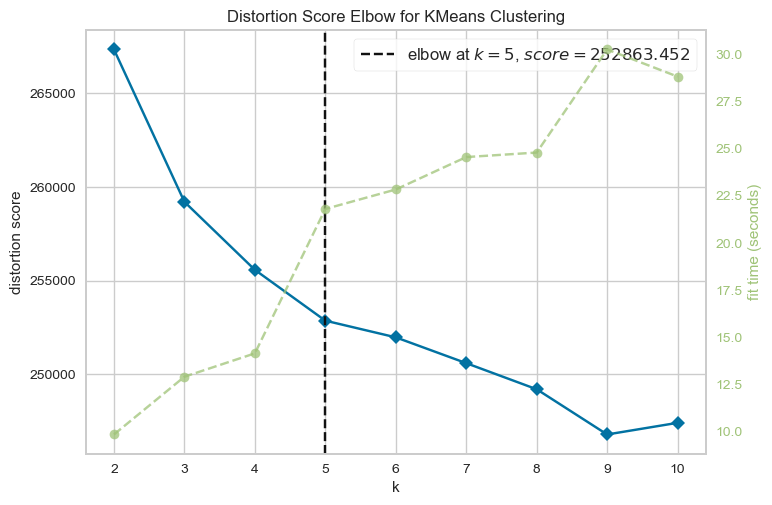

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
model_test = KMeans()
visualizer = KElbowVisualizer(model_test,K=(1,7))
visualizer.fit(df_bow)
visualizer.show()

According to BOW dataframe ---> cluster number 4
According to TF-IDF dataframe ---> cluster number 5

Here we are going to take **5 as cluster numbers**

- Term frequency adjusted for the length of the document (raw count of occurences divided by number of words in the document).

**What is IDF (inverse document frequency)?**

Inverse document frequency looks at how common (or uncommon) a word is amongst the corpus. IDF is calculated as follows where t is the term (word) we are looking to measure the commonness of and N is the number of documents (d) in the corpus (D).. The denominator is simply the number of documents in which the term, t, appears in.

In [19]:
model = KMeans(n_clusters=5,init='k-means++',random_state=42)
model.fit(df_tfv)
labels = model.predict(df_tfv)
print(labels)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
df['labels'] = labels
df.head()

### 3) Find out cluster domains

   - cluster 2 = chatgpt will take future jobs
- cluster 3 = some companies are in lose due to chatgpt etc.

In [ ]:
label_0 = df[df['labels']==0]
label_1 = df[df['labels']==1]
label_2 = df[df['labels']==2]
label_3 = df[df['labels']==3]
label_4 = df[df['labels']==4]

labels = [label_0,label_1,label_2,label_3,label_4]
for i,label in enumerate(labels):
    print("label",i,len(label))

In [ ]:
def count_producer(df):
    word_count = {}
    for col in df.columns:
        word_count[col] = sum(df[col])
    return word_count

def word_occurance(df,col):
    vectored = cv.transform(df[col])
    word_occurance = pd.DataFrame(vectored.toarray(),columns=cv.get_feature_names_out())
    return count_producer(word_occurance)

In [ ]:
word_counts = []
for label in labels:
    word_count = word_occurance(label,'cleaned')
    word_count = sorted(word_count.items(),key=lambda x:x[1],reverse=True)
    word_counts.append(word_count)
len(word_counts)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

WORD_COUNT_TO_CONSIDER = 50

In [ ]:
words = []
counts = []

for word_count in word_counts:
    lis1 = []
    lis2 = []
    for word in word_count:
        lis1.append(word[0])
        lis2.append(word[1])
    words.append(lis1)
    counts.append(lis2)
len(words),len(counts)

In [ ]:
sns.barplot(x=words[0][:WORD_COUNT_TO_CONSIDER],y=counts[0][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 0 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[1][:WORD_COUNT_TO_CONSIDER],y=counts[1][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 1 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[2][:WORD_COUNT_TO_CONSIDER],y=counts[2][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 2 ")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[3][:WORD_COUNT_TO_CONSIDER],y=counts[3][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 3")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()

In [ ]:
sns.barplot(x=words[4][:WORD_COUNT_TO_CONSIDER],y=counts[4][:WORD_COUNT_TO_CONSIDER])
plt.title(f"Most frequent {WORD_COUNT_TO_CONSIDER} words at label 4")
plt.xticks(rotation=90)
plt.xlabel("Words occured")
plt.ylabel("frequency of words")
plt.show()